# 17. Frame Selected Discriminality and ICC

In [1]:
from src import *

In [2]:
import pingouin

## Description

We evaluate frame selected's discriminality and ICC values. 

GOAL: Compute frame selected's discriminality and ICC values. 

## Table of Contents
- [Frame selected and discrim / ICC](#comparison)

<a class="anchor" id="comparison"></a>
## Frame selected (by emotion) gradients

In [3]:
# Params
embedding  = "dm" # diffusion map
aff_kernel = "pearson" #affinity matrix kernel
align_meth = "procrustes"
n_iter     = 10 # procrustes align number of iteration
nb_comp    = 3
rs         = 99

D = lambda x,y: ((x-y)**2).sum(axis=1)

Load frame selected and full movie gradients (individual level)

In [4]:
total_series = load('./data/fmri_414_series.pkl')
f_series = load('./resources/treshed_series.pkl')

if 'Rest' in f_series: del fselect_series['Rest']
if 'Rest' in total_series: del total_series['Rest']

In [5]:
fselected_series = f_series[1][(50, 80)]

In [8]:
set1 = list(fselected_series.keys())[:len(fselected_series)//2]
set2 = list(fselected_series.keys())[len(fselected_series)//2:]

In [15]:
# Group test retest
# compute threshed picked timeseries of same length

series1 = []
for mname in set1:
    tmp_dict = fselected_series[mname]
    tmp_series = list(tmp_dict.values())
    series1 += tmp_series
    
fc_selects = FC(np.concatenate(series1))
g_selects = GradientMaps(n_components=nb_comp, approach=embedding, 
                            kernel=aff_kernel, random_state=rs)
g_selects.fit(fc_selects)
grad = g_selects.gradients_
fscore = D(grad.mean(axis=0), grad)
f_selected_gradients = fscore

series2 = []
for mname in set2:
    tmp_dict = fselected_series[mname]
    tmp_series = list(tmp_dict.values())
    series2 += tmp_series
    
fc_selects = FC(np.concatenate(series2))
g_selects = GradientMaps(n_components=nb_comp, approach=embedding, 
                            kernel=aff_kernel, random_state=rs)
g_selects.fit(fc_selects)
grad = g_selects.gradients_
fscore = D(grad.mean(axis=0), grad)
f_selected_gradients2 = fscore

In [6]:
# Individual test retest
# compute threshed picked timeseries of same length
f_selected_gradients = {k:{} for k in set1}
f_selected_gradients2 = {k:{} for k in set2}

for mname in fselected_series:
    tmp_dict = fselected_series[mname]
    
    for _id in tmp_dict:
        tmp_series = tmp_dict[_id]
        
    fc_selects = FC(tmp_series)
    g_selects = GradientMaps(n_components=nb_comp, approach=embedding, 
                            kernel=aff_kernel, random_state=rs)
    g_selects.fit(fc_selects)
    grad = g_selects.gradients_
    fscore = D(grad.mean(axis=0), grad)
    f_selected_gradients[mname][_id] = fscore

### Compute ICC across movies using class as the ID

In [50]:
df = {'movieid': [], 'id': [], 'fscore': []}
df2 = {'movieid': [], 'id': [], 'fscore': []}

idx = 116
for mname in np.array(list(f_selected_gradients.keys())):
    for _id in f_selected_gradients[mname]:
        df['id'] += [int(_id[1:])]
        df['fscore'] += [f_selected_gradients[mname][_id][idx]]
        df['movieid'] += [mname]
        
        df2['id'] += [int(_id[1:])]
        df2['fscore'] += [f_selected_gradients2[mname][_id][idx]]
        df2['movieid'] += [mname]        

df = pd.DataFrame.from_dict(df)
df2 = pd.DataFrame.from_dict(df2)

icc = pingouin.intraclass_corr(data=df, targets='movieid', raters='id', ratings='fscore')
print(np.round(list(icc['ICC']),3))
icc2 = pingouin.intraclass_corr(data=df2, targets='movieid', raters='id', ratings='fscore')
print(np.round(list(icc2['ICC']),3))

[0.031 0.034 0.037 0.492 0.514 0.538]
[0.02  0.025 0.029 0.382 0.434 0.473]


In [58]:
resS1_0 = []
resS2_0 = []
resS1_3 = []
resS2_3 = []

for idx in tqdm(range(0,414)):
    df = {'movieid': [], 'id': [], 'fscore': []}
    df2 = {'movieid': [], 'id': [], 'fscore': []}
    for mname in f_selected_gradients:
        for _id in f_selected_gradients[mname]:
            df['id'] += [int(_id[1:])]
            df['fscore'] += [f_selected_gradients[mname][_id][idx]]
            df['movieid'] += [mname]

            df2['id'] += [int(_id[1:])]
            df2['fscore'] += [f_selected_gradients2[mname][_id][idx]]
            df2['movieid'] += [mname]        

    df = pd.DataFrame.from_dict(df)
    df2 = pd.DataFrame.from_dict(df2)

    icc = pingouin.intraclass_corr(data=df, targets='id', raters='movieid', ratings='fscore')
    resS1_0.append(np.round(list(icc['ICC']),3)[0])
    resS1_3.append(np.round(list(icc['ICC']),3)[3])

    icc2 = pingouin.intraclass_corr(data=df2, targets='id', raters='movieid', ratings='fscore')
    resS2_0.append(np.round(list(icc2['ICC']),3)[0])
    resS2_3.append(np.round(list(icc2['ICC']),3)[3])

  0%|          | 0/414 [00:00<?, ?it/s]

In [63]:
np.mean(resS2_0)

0.16720048309178745

In [64]:
np.mean(resS1_0)

0.1504830917874396

(array([14., 21., 46., 62., 69., 57., 53., 29., 42., 21.]),
 array([0.023 , 0.0513, 0.0796, 0.1079, 0.1362, 0.1645, 0.1928, 0.2211,
        0.2494, 0.2777, 0.306 ]),
 <BarContainer object of 10 artists>)

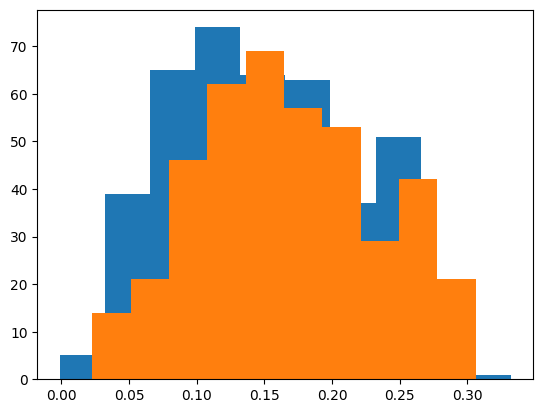

In [59]:
plt.hist(resS1_0)
plt.hist(resS2_0)

(array([  4.,   5.,   5.,  14.,   9.,  32.,  58.,  89., 105.,  93.]),
 array([0.244 , 0.3056, 0.3672, 0.4288, 0.4904, 0.552 , 0.6136, 0.6752,
        0.7368, 0.7984, 0.86  ]),
 <BarContainer object of 10 artists>)

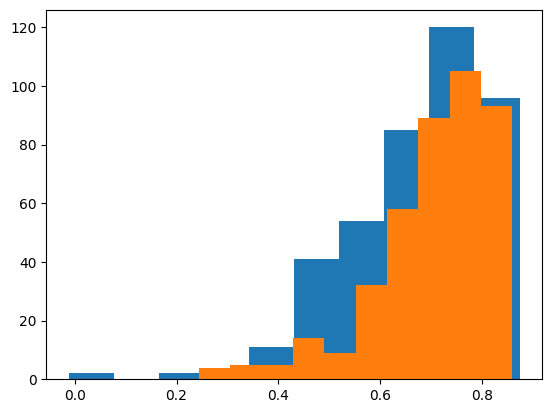

In [60]:
plt.hist(resS1_3)
plt.hist(resS2_3)

### Discriminality

In [19]:
distance = lambda x,y: 1 - pearson_correlation(x,y)

In [21]:
rec = {mname:{} for mname in f_selected_gradients}
target = f_selected_gradients['ToClaireFromSonny']['S15']
for mname in f_selected_gradients:
    for _id in f_selected_gradients[mname]:
        rec[mname][_id] = distance(target,f_selected_gradients[mname][_id])

In [30]:
pd.DataFrame.from_records(rec).T.iloc[0]

S25    0.867772
S14    0.891594
S28    0.635002
S22    0.942714
S13    0.980000
S19    0.875767
S21    0.575249
S10    0.696651
S26    0.816921
S17    0.717631
S16    0.917437
S27    0.868236
S11    0.732455
S20    0.809545
S23    0.827584
S29    0.885226
S15    0.825755
S24    0.983957
S07    0.780531
S31    0.485678
S09    1.242599
S03    0.850173
S32    0.824558
S04    0.795281
S05    0.746156
S02    0.668683
S08    0.927625
S30    0.725623
S01    1.225139
S06    0.584655
Name: AfterTheRain, dtype: float64

In [20]:
distance(f_selected_gradients['ToClaireFromSonny']['S15'],f_selected_gradients['ToClaireFromSonny']['S01'])

0.9339727433075127

In [ ]:
distance(f_selected_gradients['ToClaireFromSonny']['S15'],f_selected_gradients['ToClaireFromSonny']['S01'])